## Necessary imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# To ignore warnings
import warnings

import pandas as pd
import requests
import yaml
import yfinance as yf
from bs4 import BeautifulSoup

from utils.data import *

# from utils.data import (
#     clean_market_cap,
#     features_based_on_fundamentals,
#     features_based_on_price,
#     get_date_of_previous_month,
#     get_talib_momentum_indicators,
#     get_talib_pattern_indicators,
# )

warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


with open('../configs/external_indicators.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access indicators
fred_series = config['fred_series']
tickers_macro = config['tickers_macro']


# Verify the types
assert isinstance(fred_series, dict)
assert isinstance(tickers_macro, dict)

## Fetch table of tickers 

In [2]:
STOCKS_URL = "https://stockanalysis.com/list/nasdaq-100-stocks/"
START_DATE = '2020-01-01'
END_DATE = get_date_of_previous_month()

assert pd.to_datetime(END_DATE) < pd.to_datetime('today'), "END_DATE must be in the past"
assert pd.to_datetime(START_DATE) < pd.to_datetime(END_DATE), "START_DATE must be before END_DATE"

In [3]:
response = requests.get(STOCKS_URL)
soup = BeautifulSoup(response.text, "lxml")

table = soup.find('table')
rows = table.find_all('tr')

# Make sure to call find_all on the first row only for headers
headers = [th.text.strip() for th in rows[0].find_all('th')]
data = []
for row in rows[1:]:
    cols = [td.text.strip() for td in row.find_all('td')]
    if cols:
        data.append(cols)

df = pd.DataFrame(data, columns=headers)
number_of_stocks = len(df)
print(f"**Number of stocks in the list: {number_of_stocks}\n\n")
print(df.head())

**Number of stocks in the list: 101


  No. Symbol           Company Name Market Cap Stock Price % Change  Revenue
0   1   NVDA     NVIDIA Corporation  4,293.08B      176.67    0.24%  165.22B
1   2   MSFT  Microsoft Corporation  3,849.86B      517.93    1.86%  281.72B
2   3   AAPL             Apple Inc.  3,643.32B      245.50    3.20%  408.63B
3   4   GOOG          Alphabet Inc.  3,083.41B      255.24    1.15%  371.40B
4   5  GOOGL          Alphabet Inc.  3,080.58B      254.72    1.07%  371.40B


In [4]:
# Clean 'Market Cap' column and convert to numeric
df = clean_market_cap(df)

In [5]:
# select the top 24 stocks by Market Cap (it is alreasdy sorted by volume on the website,
# but let's be sure in case that changes in the future)

df.sort_values(by='Market Cap', ascending=False, inplace=True)
top_24_by_volume = df.head(24)

print(top_24_by_volume[['Symbol', 'Company Name', 'Market Cap']])

   Symbol                  Company Name  Market Cap
0    NVDA            NVIDIA Corporation     4293.08
1    MSFT         Microsoft Corporation     3849.86
2    AAPL                    Apple Inc.     3643.32
3    GOOG                 Alphabet Inc.     3083.41
4   GOOGL                 Alphabet Inc.     3080.58
5    AMZN              Amazon.com, Inc.     2468.71
6    META          Meta Platforms, Inc.     1955.40
7    AVGO                 Broadcom Inc.     1628.93
8    TSLA                   Tesla, Inc.     1416.75
9    NFLX                 Netflix, Inc.      521.37
10   PLTR    Palantir Technologies Inc.      432.69
11   COST  Costco Wholesale Corporation      421.82
12   ASML             ASML Holding N.V.      361.06
13   CSCO           Cisco Systems, Inc.      269.65
14   TMUS             T-Mobile US, Inc.      268.04
15    AMD  Advanced Micro Devices, Inc.      255.42
16    AZN               AstraZeneca PLC      236.24
17    LIN                     Linde plc      224.61
18    APP   

In [6]:
top_24_by_volume

,No.,Symbol,Company Name,Market Cap,Stock Price,% Change,Revenue
0,1,NVDA,NVIDIA Corporation,4293.08,176.67,0.24%,165.22B
1,2,MSFT,Microsoft Corporation,3849.86,517.93,1.86%,281.72B
2,3,AAPL,Apple Inc.,3643.32,245.50,3.20%,408.63B
3,4,GOOG,Alphabet Inc.,3083.41,255.24,1.15%,371.40B
4,5,GOOGL,Alphabet Inc.,3080.58,254.72,1.07%,371.40B
5,6,AMZN,"Amazon.com, Inc.",2468.71,231.48,0.11%,670.04B
6,7,META,"Meta Platforms, Inc.",1955.40,778.38,-0.24%,178.80B
7,8,AVGO,Broadcom Inc.,1628.93,344.94,-0.12%,59.93B
8,9,TSLA,"Tesla, Inc.",1416.75,426.07,2.21%,92.72B
9,10,NFLX,"Netflix, Inc.",521.37,"1,226.97",1.59%,41.69B


In [7]:
tickers_list =  top_24_by_volume['Symbol'].tolist()[0:]

In [8]:
tickers_list

['NVDA',
 'MSFT',
 'AAPL',
 'GOOG',
 'GOOGL',
 'AMZN',
 'META',
 'AVGO',
 'TSLA',
 'NFLX',
 'PLTR',
 'COST',
 'ASML',
 'CSCO',
 'TMUS',
 'AMD',
 'AZN',
 'LIN',
 'APP',
 'SHOP',
 'PEP',
 'INTU',
 'PDD',
 'MU']

## Feature engineering

### Price data

In [9]:
%%time 

ticker_data = dict()
dataset_price = dict()
dataset_price_df = pd.DataFrame()

for i,ticker in enumerate(tickers_list):

  print(f"{i} - Fetching data for {ticker} stock...\n")
  print("-"*24, "\n")
  
  ticker_data[ticker] = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE, interval='1d')
  price_data_by_ticker = features_based_on_price(ticker_data[ticker], ticker=ticker)
  print("-"*24, "\n")
  
  dataset_price_df = pd.concat([dataset_price_df, price_data_by_ticker], axis=0)
  dataset_price[ticker] = price_data_by_ticker
  
  if i == 1:
    break

0 - Fetching data for NVDA stock...

------------------------ 

'Adj Close' not present in columns for NVDA.Using 'Close' instead.
Data columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Data index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data shape:  (1423, 7)
Resampling to month-end frequency... 

Resampling done. The new data shape is  (68, 22)
Final data shape for NVDA:  (63, 33)
------------------------ 

1 - Fetching data for MSFT stock...

------------------------ 

'Adj Close' not present in columns for MSFT.Using 'Close' instead.
Data columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Data index type:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data shape:  (1423, 7)
Resampling to month-end frequency... 

Resampling done. The new data shape is  (68, 22)
Final data shape for MSFT:  (63, 33)
------------------------ 

CPU times: user 118 ms, 

In [10]:
dataset_price_df.ticker.value_counts()

ticker
NVDA    63
MSFT    63
Name: count, dtype: int64

In [11]:
dataset_price_df.iloc[-1]

Date                      2025-08-31 00:00:00
Close                              506.690002
ln_volume_min                       16.558349
ln_volume_median                    16.858203
ln_volume_max                       17.244184
daily_growth_min                    -0.017601
daily_growth_median                 -0.004421
daily_growth_max                     0.021999
weekly_growth_min                   -0.036789
weekly_growth_median                 -0.00395
weekly_growth_max                    0.045151
biweekly_growth_min                 -0.049835
biweekly_growth_median              -0.020656
biweekly_growth_max                  0.050151
monthly_growth_min                  -0.048692
monthly_growth_median                0.016553
monthly_growth_max                   0.073771
rel_spread_oc_median                 0.004621
rel_spread_hl_median                 0.014583
vol_10d_mean_median                 -0.002008
vol_10d_std_median                   0.012003
vol_10d_min_median                

### Fundamental features

In [12]:
%%time 

dataset_fundamentals = dict()

for i,ticker in enumerate(tickers_list):

    print(f"{i} - Fetching data for {ticker} stock...\n")
    print("-"*24, "\n")

    dataset_fundamentals[ticker] = features_based_on_fundamentals(ticker, END_DATE)

    print("-"*24, "\n")

    if i == 1:
        break

0 - Fetching data for NVDA stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

1 - Fetching data for MSFT stock...

------------------------ 

Number of missing values in fund_feats_float: 0
------------------------ 

CPU times: user 311 ms, sys: 31.9 ms, total: 343 ms
Wall time: 5.21 s


### TALIB-based indicators

In [13]:
%%time 

dataset_talib_pattern = dict()
dataset_talib_momentum = dict()

for i,ticker in enumerate(tickers_list):

    print(f"{i} - Calculate TALIB-based fearures for {ticker} stock...\n")
    print("-"*24, "\n")

    data_with_date = ticker_data[ticker].reset_index()
    data_with_date_ticker = data_with_date.copy()
    data_with_date_ticker['Ticker'] = ticker

    rows_initial = len(data_with_date_ticker)
    
    # Ensure columns are float64 before passing to TA-Lib
    # That part should resolve the issue with the `mfi` indicator, but it did not
    # TODO: investigate further if needed
    for col in ['Open', 'High', 'Low', 'Close']:
        data_with_date_ticker[col] = pd.to_numeric(data_with_date_ticker[col], errors='coerce')

    rows_after_conversion = len(data_with_date_ticker.dropna(subset=['Open', 'High', 'Low', 'Close']))
    
    if rows_initial != rows_after_conversion:
        print(f"Warning: Number of rows changed after numeric conversion for {ticker} stock: {rows_initial} -> {rows_after_conversion}")
    
    dataset_talib_pattern[ticker] = get_talib_pattern_indicators(data_with_date_ticker)
    print("# of pattern indicators calculated:", len(dataset_talib_pattern[ticker].columns))
    
    dataset_talib_momentum[ticker] = get_talib_momentum_indicators(data_with_date_ticker)
    print("# of momentum indicators calculated:", len(dataset_talib_momentum[ticker].columns))

    zeros_pattern, zeros_momentum = (dataset_talib_pattern[ticker] == 0).sum().sum(),\
                                        (dataset_talib_momentum[ticker] == 0).sum().sum()
    print(f"% of zeros in pattern indicators: {zeros_pattern /  (dataset_talib_pattern[ticker].shape[0]*dataset_talib_pattern[ticker].shape[1]):.2%} ")
    print(f"% of zeros in momentum indicators: {zeros_momentum / (dataset_talib_momentum[ticker].shape[0]*dataset_talib_momentum[ticker].shape[1]):.2%} ")

    print("-"*24, "\n")

    if i == 1:
        break

0 - Calculate TALIB-based fearures for NVDA stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indicators: 93.62% 
% of zeros in momentum indicators: 1.46% 
------------------------ 

1 - Calculate TALIB-based fearures for MSFT stock...

------------------------ 

# of pattern indicators calculated: 63
# of momentum indicators calculated: 40
% of zeros in pattern indicators: 93.60% 
% of zeros in momentum indicators: 1.41% 
------------------------ 

CPU times: user 16.2 ms, sys: 2.88 ms, total: 19 ms
Wall time: 18.4 ms


### External indicators

#### Macro Economic Indicators (fred_series)

In [14]:
dataset_fred = get_economic_indicators_fred(
    fred_mapping=fred_series, start_date=START_DATE, end_date=END_DATE)

dataset_fred

Retrieve fred series for the selected period...



,Date,gdp_us,cpi_us,unemployment_us,interest_us,gdp_de,cpi_de,interest_eu
0,2020-01-31,20693.238,259.127,3.6,1.55,748188.8,105.2175,0.315867
1,2020-02-29,20693.238,259.250,3.5,1.58,748188.8,105.5338,0.132263
2,2020-03-31,20693.238,258.076,4.4,0.65,748188.8,105.7447,0.372634
3,2020-04-30,19056.617,256.032,14.8,0.05,681793.6,105.8501,0.553776
4,2020-05-31,19056.617,255.802,13.2,0.05,681793.6,105.8501,0.479136
...,...,...,...,...,...,...,...,...
63,2025-04-30,23703.782,320.321,4.2,4.33,764275.7,127.7792,3.097221
64,2025-05-31,23703.782,320.580,4.2,4.33,764275.7,127.7792,3.070995
65,2025-06-30,23703.782,321.500,4.1,4.33,764275.7,127.7792,3.084761
66,2025-07-31,23703.782,322.132,4.2,4.33,764275.7,127.7792,3.173563


#### Major indices

In [15]:
dataset_major_indices = get_macro_market_data(
    tickers_macro=tickers_macro, start_date=START_DATE, end_date=END_DATE)

dataset_major_indices

Retrieve major tickers for the selected period...



,Date,sp500,vix,dax,spy,gld,vgk,xlv,xlk,xlf,efa,eurusd,usdx
0,2020-01-31,3225.520020,18.840000,12981.969727,295.692780,149.330002,47.198627,90.768402,90.794922,26.965891,57.435562,1.102913,97.389999
1,2020-02-29,2954.219971,40.110001,11890.349609,272.283997,148.380005,43.442020,84.789818,84.166039,23.932678,52.975540,1.099723,98.129997
2,2020-03-31,2584.590088,53.540001,9935.839844,238.283569,148.050003,36.207626,81.493736,76.946312,18.898220,45.502445,1.103047,99.050003
3,2020-04-30,2912.429932,34.150002,10861.639648,268.541626,158.800003,38.541706,91.751732,87.516022,20.686378,48.149521,1.087725,99.019997
4,2020-05-31,3044.310059,27.510000,11586.849609,281.336426,162.910004,40.792141,94.769356,93.796562,21.249151,50.762554,1.107911,98.339996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2025-04-30,5569.060059,24.700001,22496.980469,551.376831,303.769989,71.664345,139.802612,209.622574,48.593464,83.307266,1.138926,99.470001
64,2025-05-31,5911.689941,18.570000,23997.480469,586.028015,303.600006,75.448563,132.009811,230.527939,50.785950,87.298149,1.137838,99.330002
65,2025-06-30,6204.950195,16.730000,23909.609375,616.141785,304.829987,77.296791,134.789993,253.229996,52.369999,89.389999,1.172745,96.879997
66,2025-07-31,6339.390137,16.719999,24065.470703,630.332458,302.959991,75.451645,130.429993,262.739990,52.369999,87.519997,1.142936,100.029999


## Final dataset creation by merging separate dataframes

In [22]:
ticker = "MSFT"

ticker_data = dataset_price['MSFT']

# Add fundamentals data to the price data (row by row)
for k, v in dataset_fundamentals[ticker].items():
    ticker_data[k] = v

# Resample talib data to monthly end frequency and take median
df1 = dataset_talib_momentum[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()
df2 = dataset_talib_pattern[ticker].set_index('Date').drop(columns='Ticker').resample('ME').median().reset_index().dropna()

# Merge ticker_data with df1 on 'Date'
merged1 = pd.merge(ticker_data, df1, how='left', on='Date', validate='many_to_one')

# Merge the result with df2 on 'Date'
merged2 = pd.merge(merged1, df2, how='left', on='Date', validate='many_to_one')

# Merge with dataset_fred on 'Date'
merged3 = pd.merge(merged2, dataset_fred, how='left', on='Date', validate='many_to_one')

# Final merge with dataset_major_indices
final_merged = pd.merge(merged3, dataset_major_indices, how='left', on='Date', validate='many_to_one')

# final_merged now contains columns from all three DataFrames, joined on 'Date'
final_merged.shape

(63, 181)

In [24]:
'ticker' in final_merged.columns

True

In [25]:
'Ticker' in final_merged.columns

False

In [26]:
final_merged.head()

,Date,Close,ln_volume_min,ln_volume_median,ln_volume_max,daily_growth_min,daily_growth_median,daily_growth_max,weekly_growth_min,weekly_growth_median,weekly_growth_max,biweekly_growth_min,biweekly_growth_median,biweekly_growth_max,monthly_growth_min,monthly_growth_median,monthly_growth_max,rel_spread_oc_median,rel_spread_hl_median,vol_10d_mean_median,vol_10d_std_median,vol_10d_min_median,vol_10d_max_median,return_1m,return_2m,...,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,gdp_us,cpi_us,unemployment_us,interest_us,gdp_de,cpi_de,interest_eu,sp500,vix,dax,spy,gld,vgk,xlv,xlk,xlf,efa,eurusd,usdx
0,2020-06-30,194.659973,16.934451,17.305773,17.816932,-0.053698,0.007163,0.037092,-0.013209,0.019030,0.061934,-0.014758,0.043897,0.082669,0.014768,0.055202,0.113111,-0.003541,0.025154,0.004455,0.016424,-0.020158,0.027774,0.110559,0.138758,...,0.0,0.0,0.0,0.0,0.0,0.0,19056.617,257.042,11.0,0.08,681793.6,105.9555,0.351459,3100.290039,30.430000,12310.929688,286.325806,167.369995,42.396267,92.454552,100.314522,21.138050,52.544918,1.124720,97.389999
1,2020-07-31,196.094757,16.792702,17.301268,18.027001,-0.043495,0.002330,0.042981,-0.050498,0.004317,0.073193,-0.057893,0.007385,0.083300,0.001514,0.073761,0.151870,-0.002894,0.022642,0.000946,0.017130,-0.030889,0.027774,0.007371,0.118745,...,0.0,0.0,0.0,0.0,0.0,0.0,20548.793,258.352,10.2,0.09,740949.7,105.1121,0.220885,3271.120117,24.459999,12313.360352,303.188080,185.429993,43.946217,97.499054,106.017159,21.951054,53.563522,1.187225,93.489998
2,2020-08-31,216.243866,16.703596,17.148183,18.184743,-0.023385,0.003145,0.056241,-0.046462,0.030660,0.074594,-0.028909,0.023346,0.098436,-0.025366,0.022521,0.125372,-0.000670,0.019465,0.002597,0.017445,-0.023385,0.028567,0.102752,0.110880,...,0.0,0.0,0.0,0.0,0.0,0.0,20548.793,259.316,8.4,0.10,740949.7,105.1121,0.160072,3500.310059,26.410000,12945.379883,324.349609,184.830002,45.841541,100.021278,118.612900,22.891947,56.092808,1.191824,92.139999
3,2020-09-30,201.669754,16.898516,17.330635,17.904241,-0.061947,0.006764,0.042584,-0.113447,-0.013972,0.049891,-0.124067,-0.023930,0.104674,-0.094579,-0.026289,0.088705,-0.001724,0.031253,-0.001882,0.025886,-0.054096,0.024554,-0.067397,0.028430,...,0.0,0.0,0.0,0.0,0.0,0.0,20548.793,259.997,7.8,0.09,740949.7,105.1121,0.123464,3363.000000,26.370001,12760.730469,312.204834,177.119995,44.412704,97.840355,112.284767,22.108530,54.944710,1.174205,93.889999
4,2020-10-31,194.133377,16.753593,17.104133,17.751164,-0.049566,0.001353,0.025902,-0.063636,-0.007183,0.082318,-0.082314,0.031416,0.075268,-0.109907,0.035480,0.085134,-0.000480,0.020321,0.003278,0.018442,-0.029511,0.024465,-0.037370,-0.102248,...,0.0,0.0,0.0,0.0,0.0,0.0,20771.691,260.319,6.9,0.09,748115.7,105.3230,0.000361,3269.959961,38.020000,11556.480469,304.420410,176.199997,42.006977,94.297035,106.665726,21.915646,52.993797,1.167870,94.040001


In [29]:
final_merged = final_merged.sort_values('Date')  # Ensure sorted by date
final_merged['TARGET'] = final_merged['Close'].shift(-1)

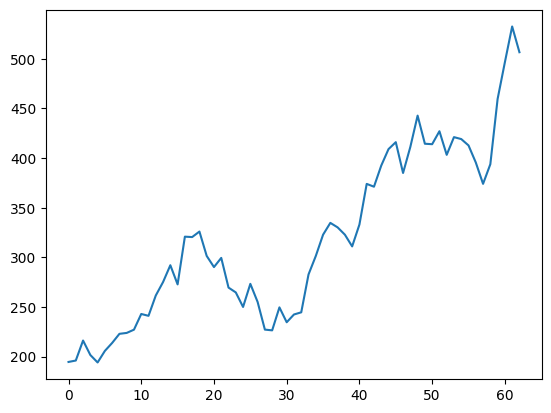

In [32]:
final_merged.Close.plot();

In [33]:
final_merged.isnull().sum().sum()

np.int64(1)